<a href="https://colab.research.google.com/github/niplessa/Thesis_Data-mining-study-on-medical-and-sociological-Data-regarding-Covid19/blob/main/NLP3_FakeNews_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classifier to predict if a COVID-19 related article is fake or not.

In [ ]:
#import libraries
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import regexp_tokenize 
from string import punctuation
from nltk.stem import WordNetLemmatizer 

stopwords = stopwords.words('english')


from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
path = 'https://raw.githubusercontent.com/niplessa/Datasets/main/corona_fake.csv'
data=pd.read_csv(path)

## Data preproccessing

In [ ]:
data.head(10)

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake
5,CORONA UNMASKED: Chinese Intelligence Officer ...,NaN,NaN,NaN
6,NaN,Urgent: Health Bulletin to the Public. Ministr...,Ministry of Health,Fake
7,NaN,"Pls tell ur families, relatives and friendsMOH...",NWLLAB,Fake
8,NaN,SERIOUS EXCELLENT ADVICE by Japanese doctors t...,Japanese doctors treating COVID-19 cases,Fake
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,TRUE


In [ ]:
data.text[0]

'You just need to add water, and the drugs and vaccines are ready to be administered. There are two parts to the kit: one holds pellets containing the chemical machinery that synthesises the end product, and the other holds pellets containing instructions that telll the drug which compound to create. Mix two parts together in a chosen combination, add water, and the treatment is ready.'

In [ ]:
data.text[9]

'Stay aware of the latest information on the COVID-19 outbreak, available on the WHO website and through your national and local public health authority. Most people who become infected experience mild illness and recover, but it can be more severe for others. Take care of your health and protect others by doing the following: Wash your hands frequently. Regularly and thoroughly clean your hands with an alcohol-based hand rub or wash them with soap and water.Why? Washing your hands with soap and water or using alcohol-based hand rub kills viruses that may be on your hands. Maintain social distancing. Maintain at least 1 metre (3 feet) distance between yourself and anyone who is coughing or sneezing. Why? When someone coughs or sneezes they spray small liquid droplets from their nose or mouth which may contain virus. If you are too close, you can breathe in the droplets, including the COVID-19 virus if the person coughing has the disease. Avoid touching eyes, nose and mouth. Why? Hands 

In [ ]:
data['label'].value_counts()

TRUE    584
Fake    345
fake    230
Name: label, dtype: int64

Change all labels to "FAKE" and "TRUE"

In [ ]:
data["label"]= data["label"].str.replace("fake", "FAKE", case = False) #change everything to FAKE
data["label"]= data["label"].str.replace("Fake", "FAKE", case = False)

In [ ]:
data['label'].value_counts()

TRUE    584
FAKE    575
Name: label, dtype: int64

In [ ]:
label_column=data['label'].isnull() #find null values in label
label_column

0       False
1       False
2       False
3       False
4       False
        ...  
1159    False
1160    False
1161    False
1162    False
1163    False
Name: label, Length: 1164, dtype: bool

In [ ]:
#get all null data values
for i in range (data.shape[0]):
    if(label_column[i]==True):
        print(i)


5
15
43
131
242


Inspect manually and anotate the m5 missing labels

In [ ]:
data.loc[5]['label'] = 'FAKE'
data.loc[15]['label'] = 'TRUE'
data.loc[43]['label'] = 'FAKE'
data.loc[131]['label'] = 'TRUE'
data.loc[242]['label'] = 'FAKE'

In [ ]:
#fill missing values with blank text
data.isnull().sum()

title     82
text      10
source    20
label      0
dtype: int64

In [ ]:
data=data.fillna(' ')
print(data.isnull().sum())

title     0
text      0
source    0
label     0
dtype: int64


## Find most fake news data sources / ΕDA

will be used later 

In [ ]:
data[data['label']=='FAKE'].source.value_counts()

Facebook                           49
https://www.naturalnews.com/       25
http://orthomolecular.org/         21
https://web.archive.org/           21
                                   19
                                   ..
https://www.express.co.uk/          1
reddit.com                          1
https://thefreedomarticles.com/     1
CharlieKirk                         1
https://www.aubedigitale.com/       1
Name: source, Length: 185, dtype: int64

In [ ]:
data[data['label']=='TRUE'].source.value_counts()

https://www.health.harvard.edu/            102
https://www.nytimes.com/                    62
https://www.globalhealthnow.org/            56
https://www.who.int/                        49
https://www.cdc.gov/                        38
                                          ... 
https://www.scmp.com/                        1
https://www.sciencedaily.com/                1
canada.ca                                    1
https://fullfact.org/                        1
https://www.washingtonpost.com/opinions      1
Name: source, Length: 89, dtype: int64

##Text cleaning

In [ ]:
data['complete_text']=data['text']+' '+data['title']

In [ ]:
#lematization function
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

In [ ]:
#remove stopwords function
stops =  list(stopwords)
def remove_stops(text):
    text_no_stops = []
    for i in text:
        if i not in stops:
            if len(i) == 1:
                pass
            else:
                text_no_stops.append(i)
        else:
            pass
    return text_no_stops

In [ ]:
data['complete_text'] = data['complete_text'].apply(lambda x: x.lower())

# removing everything except alphabets
data['complete_text'] = data['complete_text'].str.replace("[^a-zA-Z]", " ")

# removing short words <3 letters length
data['complete_text'] = data['complete_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>=3]))

# tokenization
data['text_tokenized'] = data['complete_text'].apply(lambda x: regexp_tokenize(x,"[\w']+"))

#actually remove stopwords
data['text_tokenized'] = data['text_tokenized'].apply(lambda x: remove_stops(x))

#lemmatization
data['text_lemmatized'] = data['text_tokenized'].apply(lemmatize_text)

#stemming
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 
data['text_stemmed'] = data['text_lemmatized'].apply(lambda x: [ps.stem(y) for y in x])

#de - tokenization
data['stemmed_string'] = data['text_stemmed'].apply(lambda x: ' '.join(x))
data['lemmatized_string'] = data['text_lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
data.head()

,title,text,source,label,complete_text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,FAKE,you just need add water and the drugs and vacc...,"[need, add, water, drugs, vaccines, ready, adm...","[need, add, water, drug, vaccine, ready, admin...","[need, add, water, drug, vaccin, readi, admini...",need add water drug vaccin readi administ two ...,need add water drug vaccine ready administered...
1,,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,FAKE,hydroxychloroquine has been shown have effecti...,"[hydroxychloroquine, shown, effective, rate, t...","[hydroxychloroquine, shown, effective, rate, t...","[hydroxychloroquin, shown, effect, rate, treat...",hydroxychloroquin shown effect rate treat covi...,hydroxychloroquine shown effective rate treati...
2,,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,FAKE,fact hydroxychloroquine has been shown have ef...,"[fact, hydroxychloroquine, shown, effective, r...","[fact, hydroxychloroquine, shown, effective, r...","[fact, hydroxychloroquin, shown, effect, rate,...",fact hydroxychloroquin shown effect rate treat...,fact hydroxychloroquine shown effective rate t...
3,,The Corona virus is a man made virus created i...,JoanneWrightForCongress,FAKE,the corona virus man made virus created wuhan ...,"[corona, virus, man, made, virus, created, wuh...","[corona, virus, man, made, virus, created, wuh...","[corona, viru, man, made, viru, creat, wuhan, ...",corona viru man made viru creat wuhan laborato...,corona virus man made virus created wuhan labo...
4,,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,FAKE,doesn billgates finance research the wuhan lab...,"[billgates, finance, research, wuhan, lab, cor...","[billgates, finance, research, wuhan, lab, cor...","[billgat, financ, research, wuhan, lab, corona...",billgat financ research wuhan lab corona viru ...,billgates finance research wuhan lab corona vi...


In [ ]:
data.complete_text[0]

'you just need add water and the drugs and vaccines are ready administered there are two parts the kit one holds pellets containing the chemical machinery that synthesises the end product and the other holds pellets containing instructions that telll the drug which compound create mix two parts together chosen combination add water and the treatment ready due the recent outbreak for the coronavirus covid the world health organization giving away vaccine kits just pay for shipping'

In [ ]:
data.lemmatized_string[0]

'need add water drug vaccine ready administered two part kit one hold pellet containing chemical machinery synthesis end product hold pellet containing instruction telll drug compound create mix two part together chosen combination add water treatment ready due recent outbreak coronavirus covid world health organization giving away vaccine kit pay shipping'

In [ ]:
data.stemmed_string[0]

'need add water drug vaccin readi administ two part kit one hold pellet contain chemic machineri synthesi end product hold pellet contain instruct telll drug compound creat mix two part togeth chosen combin add water treatment readi due recent outbreak coronaviru covid world health organ give away vaccin kit pay ship'

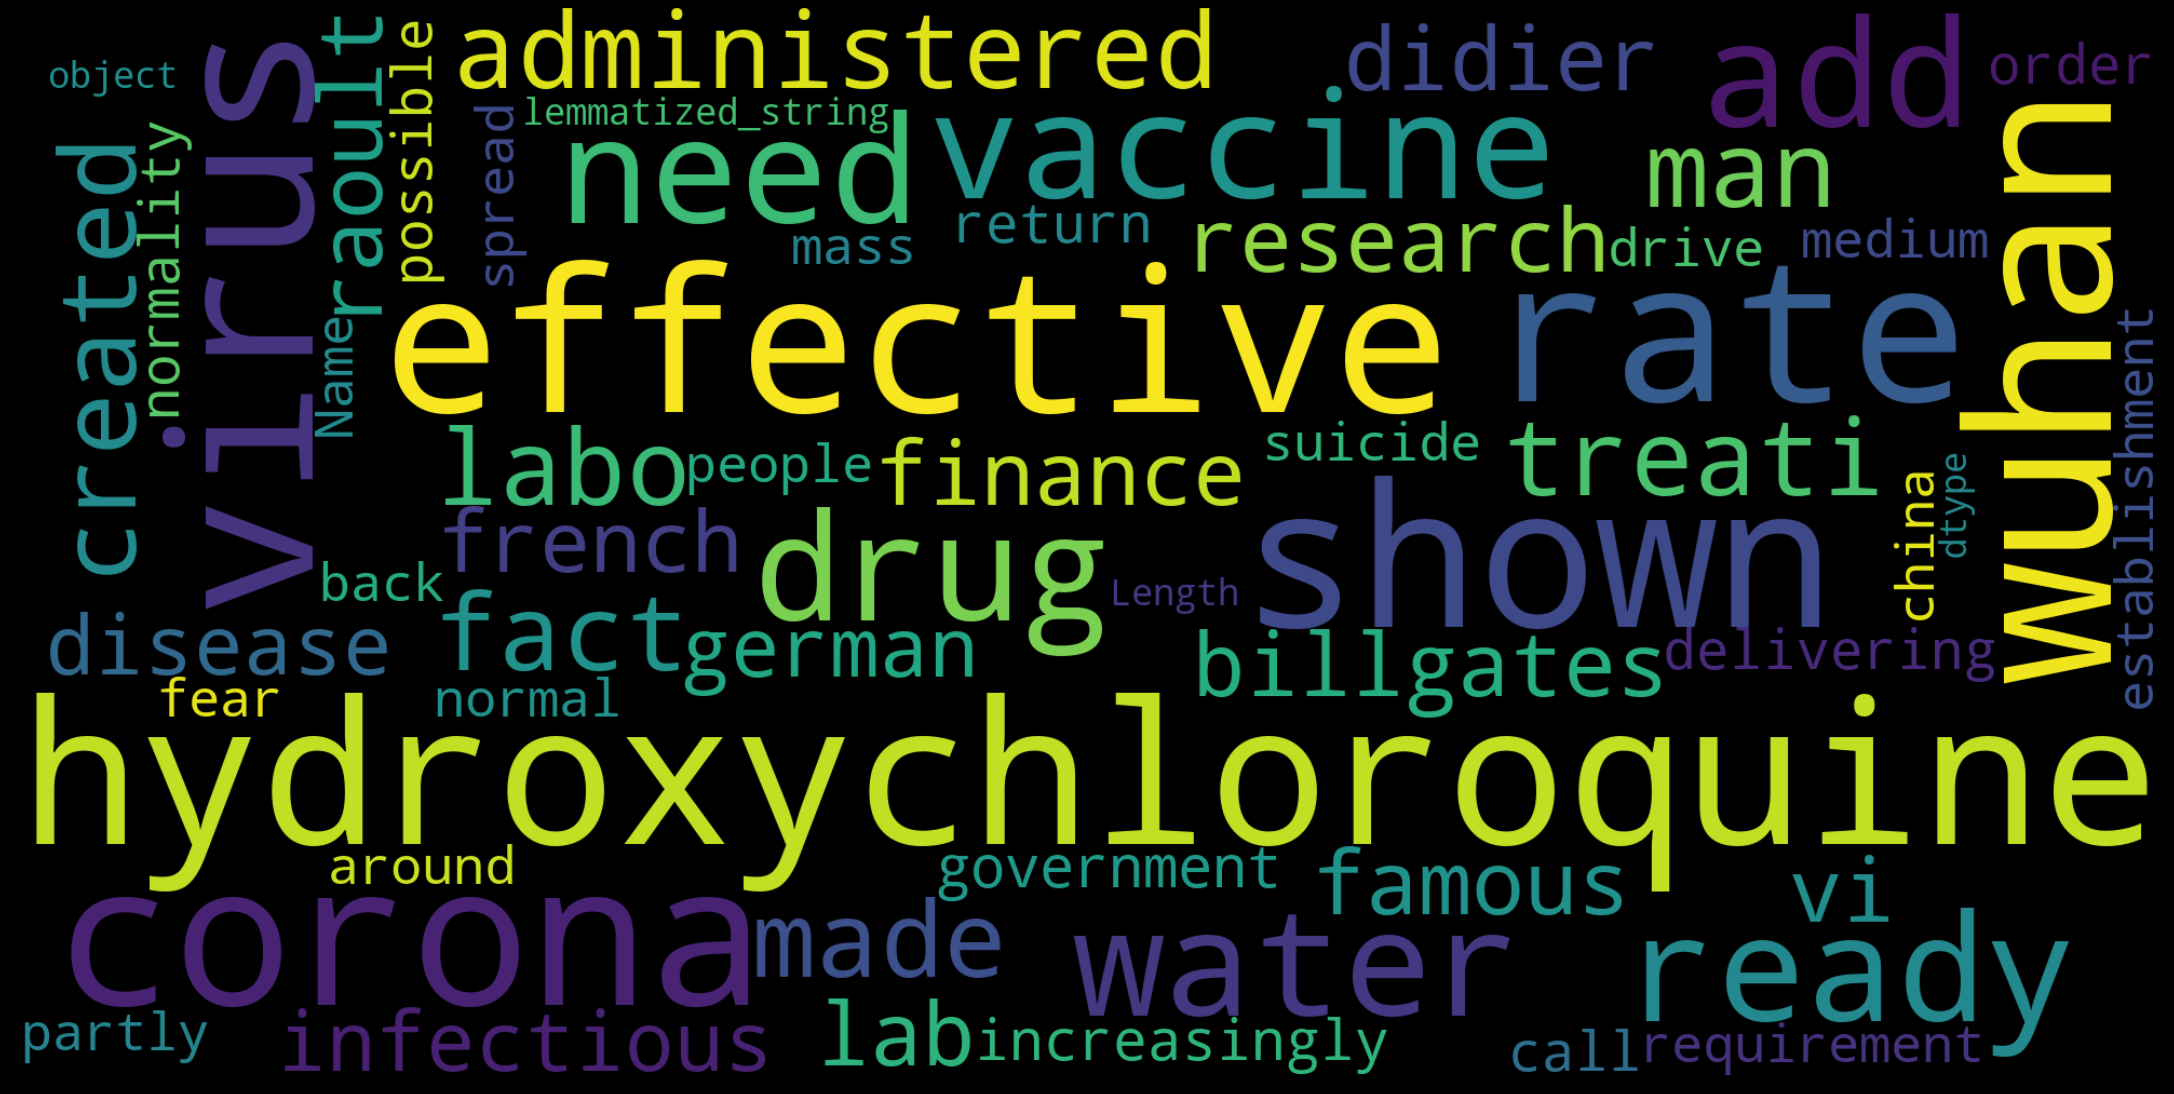

In [ ]:
df = data[data['label']=='FAKE']
text = df.lemmatized_string
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = stopwords).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

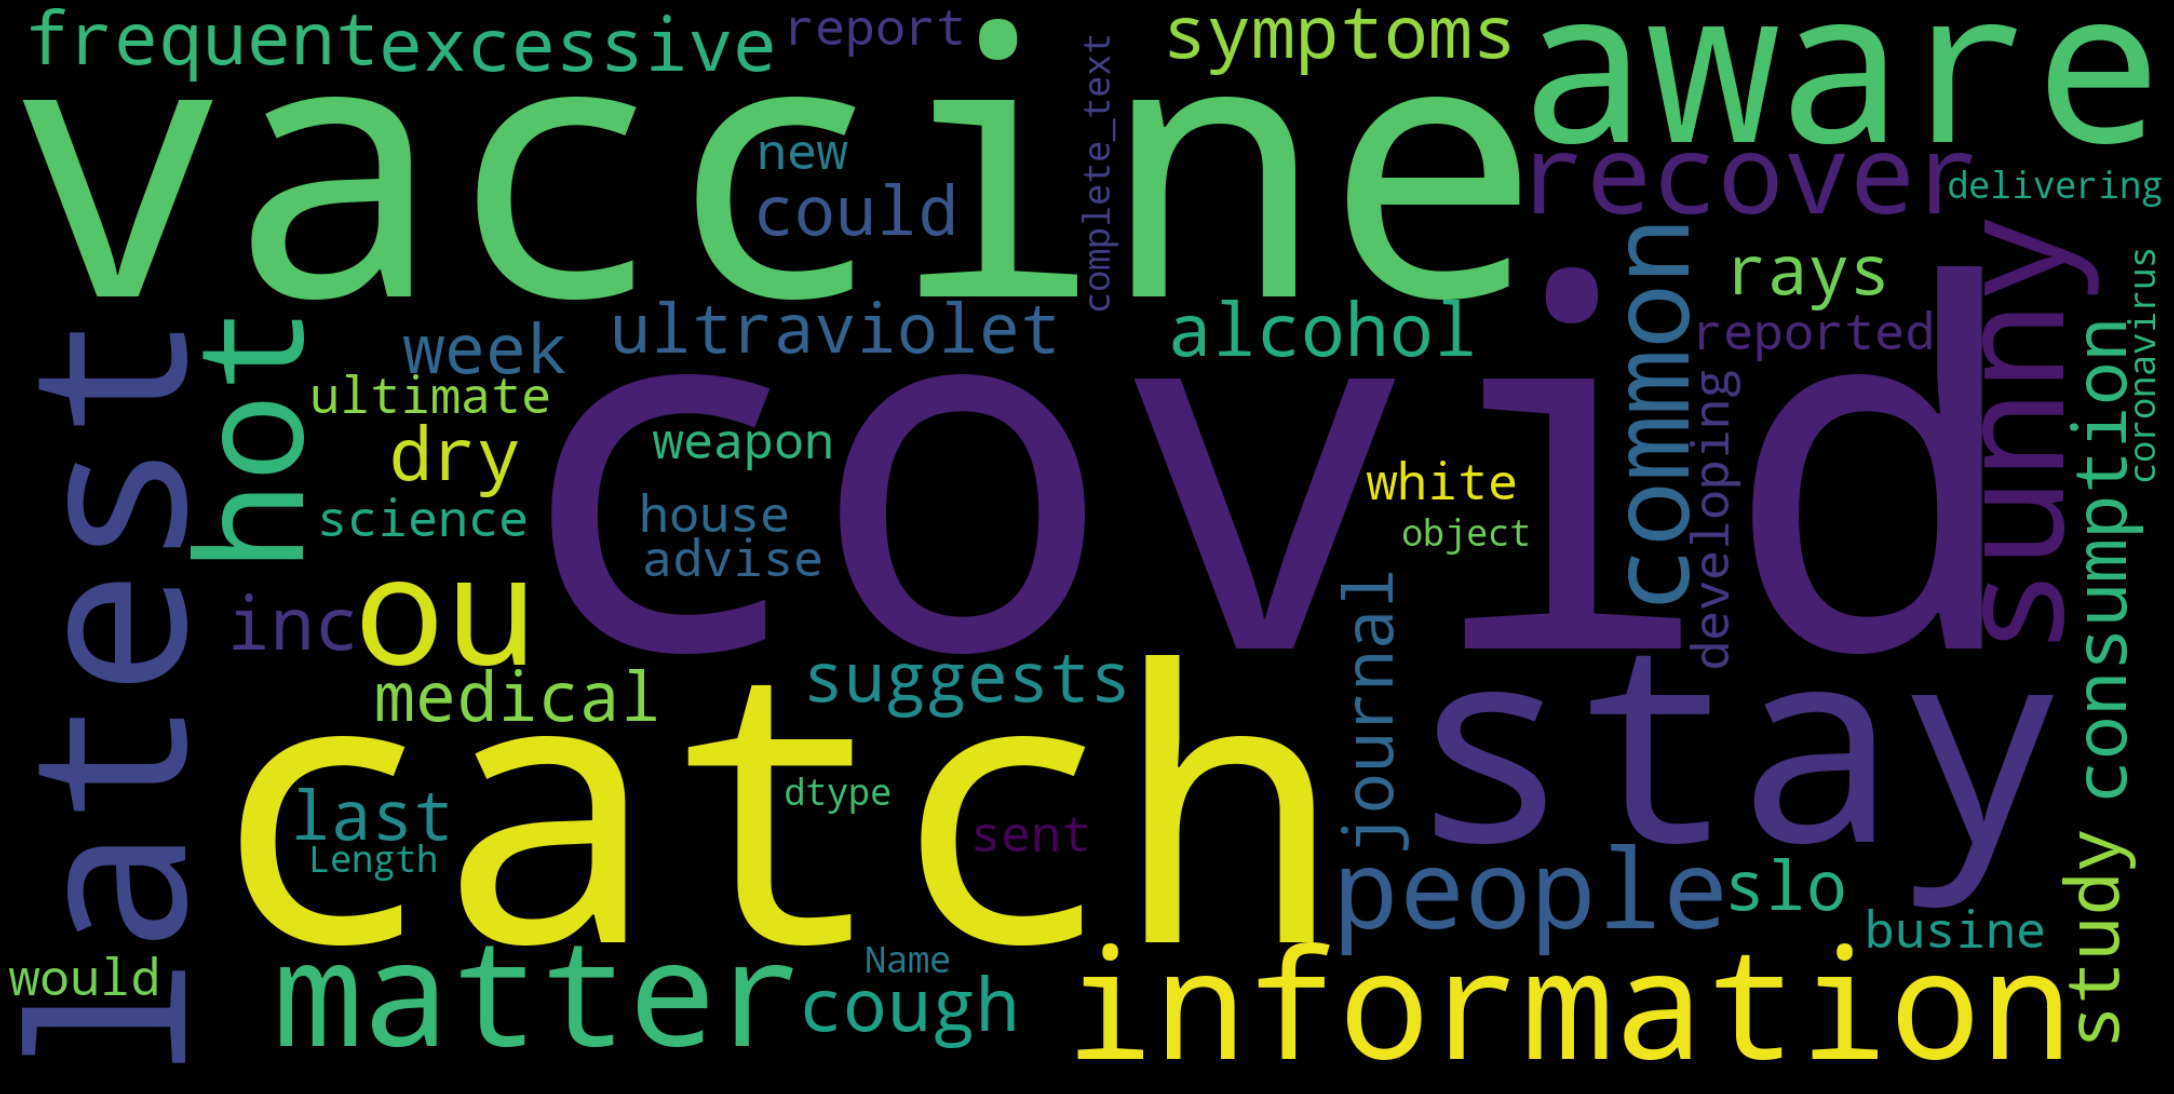

In [ ]:
df = data[data['label']=='TRUE']
text = df.complete_text
wordcloud = WordCloud(
    max_words = 1000,
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = stopwords).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#Classification

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Label Encoding

In [ ]:
mask = {'TRUE': 1, 
        'FAKE': 0}
data = data.replace(mask) #replace values


In [ ]:
data.head()

,title,text,source,label,complete_text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,0,you just need add water and the drugs and vacc...,"[need, add, water, drugs, vaccines, ready, adm...","[need, add, water, drug, vaccine, ready, admin...","[need, add, water, drug, vaccin, readi, admini...",need add water drug vaccin readi administ two ...,need add water drug vaccine ready administered...
1,,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,0,hydroxychloroquine has been shown have effecti...,"[hydroxychloroquine, shown, effective, rate, t...","[hydroxychloroquine, shown, effective, rate, t...","[hydroxychloroquin, shown, effect, rate, treat...",hydroxychloroquin shown effect rate treat covi...,hydroxychloroquine shown effective rate treati...
2,,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,0,fact hydroxychloroquine has been shown have ef...,"[fact, hydroxychloroquine, shown, effective, r...","[fact, hydroxychloroquine, shown, effective, r...","[fact, hydroxychloroquin, shown, effect, rate,...",fact hydroxychloroquin shown effect rate treat...,fact hydroxychloroquine shown effective rate t...
3,,The Corona virus is a man made virus created i...,JoanneWrightForCongress,0,the corona virus man made virus created wuhan ...,"[corona, virus, man, made, virus, created, wuh...","[corona, virus, man, made, virus, created, wuh...","[corona, viru, man, made, viru, creat, wuhan, ...",corona viru man made viru creat wuhan laborato...,corona virus man made virus created wuhan labo...
4,,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,0,doesn billgates finance research the wuhan lab...,"[billgates, finance, research, wuhan, lab, cor...","[billgates, finance, research, wuhan, lab, cor...","[billgat, financ, research, wuhan, lab, corona...",billgat financ research wuhan lab corona viru ...,billgates finance research wuhan lab corona vi...


In [ ]:
y=data.label
data.drop("label", axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['stemmed_string'], y, test_size=0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(931,) (931,)
(233,) (233,)


In [ ]:
X_train

116    dangersconspiracycontrolcoronavirusther connec...
840    anyth urgent postpon safer time would includ c...
681    coronaviru symptom includ fever dri cough shor...
933    commonli report mainstream medium account crea...
73     coronaviru way prevent itali leav buy germani ...
                             ...                        
497    break news china conduct clinic trial day intr...
222    atlanta effort stop spread potenti lethal path...
403    microsoft founder bill gate launch human impla...
410    anthoni fauci said friday cnn new day idea ame...
601    hyster overreact coronaviru driven govern virt...
Name: stemmed_string, Length: 931, dtype: object

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords, 
#max_features= 1000, # keep top 1000 terms
max_df=0.80)
#smooth_idf=True,
#use_idf = True,)

tfidf_train = vectorizer.fit_transform(X_train) 
tfidf_test = vectorizer.transform(X_test)

## Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier(random_state=42)

clf.fit(tfidf_train,y_train)
y_pred = clf.predict(tfidf_test)

print("\nClassification report for Decision Trees on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Deceased (TN) = {} , False Relased (FP) = {}, False  Deceased (FN) = {}, True Released (TP) = {}".format(tn,fp,fn,tp))

labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), index=labels, columns=labels)

# CM visualization
cm


Classification report for Decision Trees on test
              precision    recall  f1-score   support

           0       0.69      0.81      0.75       108
           1       0.81      0.69      0.74       125

    accuracy                           0.75       233
   macro avg       0.75      0.75      0.75       233
weighted avg       0.76      0.75      0.75       233

True Deceased (TN) = 88 , False Relased (FP) = 20, False  Deceased (FN) = 39, True Released (TP) = 86


,0,1
0,88,20
1,39,86


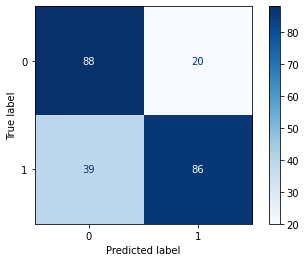

In [ ]:
disp = plot_confusion_matrix(clf, tfidf_test, y_test,
                              values_format = 'd',
                              #labels = labels,
                                 cmap=plt.cm.Blues)
                                 
plt.show()

## KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(tfidf_train, y_train)

y_pred = clf.predict(tfidf_test)

print("\nClassification report for KNN clasifier on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Deceased (TN) = {} , False Relased (FP) = {}, False  Deceased (FN) = {}, True Released (TP) = {}".format(tn,fp,fn,tp))

labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), index=labels, columns=labels)

# CM visualization
cm


Classification report for KNN clasifier on test
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       108
           1       0.82      0.94      0.87       125

    accuracy                           0.85       233
   macro avg       0.86      0.85      0.85       233
weighted avg       0.86      0.85      0.85       233

True Deceased (TN) = 82 , False Relased (FP) = 26, False  Deceased (FN) = 8, True Released (TP) = 117


,0,1
0,82,26
1,8,117


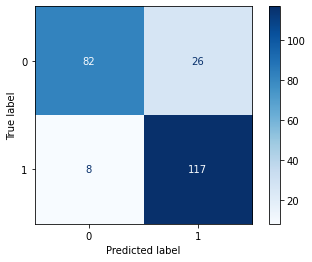

In [ ]:
disp = plot_confusion_matrix(clf, tfidf_test, y_test,
                             values_format = 'd',
                                 cmap=plt.cm.Blues)
                                 
plt.show()

## SVM Classifier

In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(tfidf_train, y_train)

y_pred = clf.predict(tfidf_test)

print("\nClassification report for KNN clasifier on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Deceased (TN) = {} , False Relased (FP) = {}, False  Deceased (FN) = {}, True Released (TP) = {}".format(tn,fp,fn,tp))

labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), index=labels, columns=labels)

# CM visualization
cm


Classification report for KNN clasifier on test
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       108
           1       0.96      0.94      0.95       125

    accuracy                           0.94       233
   macro avg       0.94      0.94      0.94       233
weighted avg       0.94      0.94      0.94       233

True Deceased (TN) = 103 , False Relased (FP) = 5, False  Deceased (FN) = 8, True Released (TP) = 117


,0,1
0,103,5
1,8,117


##Random **Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:

clf = RandomForestClassifier(random_state=42)
clf.fit(tfidf_train, y_train)
y_pred = clf.predict(tfidf_test)

print("\nClassification report for KNN clasifier on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Deceased (TN) = {} , False Relased (FP) = {}, False  Deceased (FN) = {}, True Released (TP) = {}".format(tn,fp,fn,tp))

labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), index=labels, columns=labels)

# CM visualization
cm


Classification report for KNN clasifier on test
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       108
           1       0.95      0.86      0.90       125

    accuracy                           0.90       233
   macro avg       0.90      0.90      0.90       233
weighted avg       0.90      0.90      0.90       233

True Deceased (TN) = 102 , False Relased (FP) = 6, False  Deceased (FN) = 18, True Released (TP) = 107


,0,1
0,102,6
1,18,107


##Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:

clf = AdaBoostClassifier(random_state=42)
clf.fit(tfidf_train, y_train)
y_pred = clf.predict(tfidf_test)

print("\nClassification report for KNN clasifier on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Deceased (TN) = {} , False Relased (FP) = {}, False  Deceased (FN) = {}, True Released (TP) = {}".format(tn,fp,fn,tp))

labels = np.unique(y_test)
## DF with C.M.
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), index=labels, columns=labels)

# CM visualization
cm


Classification report for KNN clasifier on test
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       108
           1       0.84      0.83      0.84       125

    accuracy                           0.82       233
   macro avg       0.82      0.82      0.82       233
weighted avg       0.82      0.82      0.82       233

True Deceased (TN) = 88 , False Relased (FP) = 20, False  Deceased (FN) = 21, True Released (TP) = 104


,0,1
0,88,20
1,21,104


## Τune SVM hyper-parameters

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.1, 1, 10],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = svm.SVC(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy')
grid_search.fit(tfidf_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(tfidf_test)

print("\nClassification report for SVM on test")
print(classification_report(y_test, y_pred))

#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("SVM classifier Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("True Negative (TN) = {} , False Positive (FP) = {}, False  Negative (FN) = {}, True Positive (TP) = {}".format(tn,fp,fn,tp))



Best estimator is:{'C': 10, 'class_weight': {1: 1}, 'kernel': 'rbf'}
F1-Score (macro avg) on train: 92.16%

Classification report for SVM on test
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       108
           1       0.96      0.94      0.95       125

    accuracy                           0.95       233
   macro avg       0.95      0.95      0.95       233
weighted avg       0.95      0.95      0.95       233

SVM classifier Confusion Matrix: 
 [[103   5]
 [  7 118]]
True Negative (TN) = 103 , False Positive (FP) = 5, False  Negative (FN) = 7, True Positive (TP) = 118


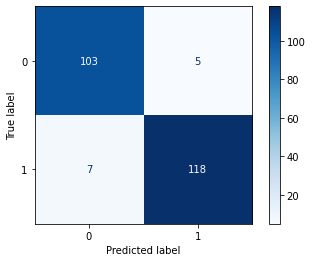

In [ ]:
disp = plot_confusion_matrix(grid_search.best_estimator_, tfidf_test, y_test,
                             values_format = 'd',
                                 cmap=plt.cm.Blues)
                                 
plt.show()

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('clf',grid_search.best_estimator_)])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=10, break_ties=False, cache_size=200,
                     class_weight={1: 1}, coef0=0.0,
                     decisio

In [ ]:
text = "“During the 2009 swine flu outbreak, Biden made reckless comments unsupported by science & the experts. The Obama Admin had to clean up his mess & apologize for his ineptitude"

In [ ]:
result=pipeline.predict([text])
print(result)

[0]


In [ ]:
text = '''Danish study finds no clear evidence face masks protect wearer from Covid-19 infection A major Danish study has found face masks give no clear protection from Covid-19 infection to the wearer, but did not examine whether the wearer protects others by using the item.
The study compared how well protected one group of people who used masks were compared with a second group who did not use them. The results of the study were announced in a statement released by Copenhagen’s Rigshospitalet.
It is important to note that the study looked exclusively at the protective effects of masks for the wearer, and not at the wearer’s ability to protect others.
As such, the study cannot be used to draw conclusions on the general merits of using face masks as an effective preventative measure against Covid-19 infection, the researchers behind the study said.
The research project involved two groups totalling 6,000 people, and was conducted in April and May this year, when face mask use was not widespread in Denmark.
During this period, Denmark’s lockdown was still ongoing, with many businesses and public institutions closed
In the non-face mask group, 2.1 percent of participants were infected with new coronavirus, while 1.8 percent of participants in the face mask-wearing group were infected.
That difference is not big enough to conclude with certainty a benefit of using face masks with regard to protecting oneself from infection.
The researchers stressed that there are limits to the conclusions that can be drawn from the results.
“The study thereby fails to confirm the expected halving of risk of infection for the wearer of the face mask, but the results could suggest a moderate level of protection of 15-20 percent,” the Danish-language press statement notes.
“According to the study authors, their findings offer evidence about the degree of protection mask wearers can anticipate in a setting where others are not wearing masks and where other public health measures, including social distancing, are in effect,” reads the English-language counterpart.
“The findings, however, should not be used to conclude that a recommendation for everyone to wear masks in the community would not be effective in reducing SARS-CoV-2 infections, because the trial did not test the role of masks in source control (transmission from an infected person to others) of SARS-CoV-2 infection,” it adds. '''


In [ ]:
result=pipeline.predict([text])
print(result)

[1]


fake news from natural news

In [ ]:
text = '''COVID19 – Evidence of global fraud
COVID 19, and the subsequent governmental responses, appear to be part of an international conspiracy to commit fraud. It seems there is no evidence that a virus called SARS-CoV-2 causes a disease called COVID 19.Sometimes you have to go with your gut. I am not an expert in genetics and, as ever, stand to be corrected. However my attention was drawn to some research published by the Spanish medical journal D-Salud-Discovery. Their advisory board of eminently qualified physicians and scientists lends further credibility to their research. Their claim is astounding.

The genetic primers and probes used in RT-PCR tests to identify SARS-CoV-2 do not target anything specific. I followed the search techniques outlined in this English translation of their report and can corroborate the accuracy of their claims about the nucleotide sequences listed in the World Health Organisations protocols. You can do the same.

D-Salud-Discovery state there are no tests capable of identifying SARS-CoV-2. Consequently, all claims about the alleged impact of COVID 19 on population health are groundless.

The entire official COVID 19 narrative is a deception. Ostensibly, there is no scientific foundation for any part of it.

If these claims are accurate we can state that there is no evidence of a pandemic, merely the illusion of one. We have suffered incalculable loss for no evident reason, other than the ambitions of unscrupulous despots who wish to transform the global economy and our society to suit their purposes.

In doing so this “parasite class” have potentially committed countless crimes. These crimes can and should be investigated and prosecuted in a court of law.

IDENTIFICATION OF WHAT EXACTLY?
The World Health Organisation (WHO) classified COVID-19 (COronaVIrus Disease 2019). They declared a global COVID 19 pandemic on March 11th 2019.

The WHO’s Laboratory testing guidance states:

The etiologic agent [causation for the disease] responsible for the cluster of pneumonia cases in Wuhan has been identified as a novel betacoronavirus, (in the same family as SARS-CoV and MERS-CoV) via next generation sequencing (NGS) from cultured virus or directly from samples received from several pneumonia patients.”

The WHO’s claim is that the SARS-CoV-2 virus causes the disease COVID-19. They also allege this virus has been clearly identified by researchers in Wuhan.

In the WHO’s Novel Coronavirus 2019-nCov Situation Report 1, they state:

The Chinese authorities identified a new type of coronavirus, which was isolated on 7 January 2020……On 12 January 2020, China shared the genetic sequence of the novel coronavirus for countries to use in developing specific diagnostic kits.”

These two statements from the WHO clearly suggest the SARS-CoV-2 virus was isolated (meaning purified for study) and then genetic sequences were identified from the isolated sample. From this, diagnostic kits were developed and distributed globally to test for the virus in towns, cities and communities around the world. According to the WHO and Chinese researchers, these tests will find the virus that causes COVID 19.

Yet the WHO also state:

Working directly from sequence information, the team developed a series of genetic amplification (PCR) assays used by laboratories.”

The Wuhan scientists developed their genetic amplification assays from “sequence information” because there was no isolated, purified sample of the so called SARS-CoV-2 virus. They also showed electron microscope images of the newly discovered virions (the spiky protein ball containing the viral RNA.)

However, such protein structures are not unique. They look just like other round vesicles, such as endocytic vesicles and exosomes.

Virologists claim that it is not possible to “isolate” a virus because they only replicate inside host cells. They add that Koch’s postulates do not apply because they relate to bacteria (which are living organisms). Instead, virologists observe the virus’ cytopathogenic effects (CPE), causing cell mutation and degradation, in cell cultures.

When Chinese researchers first sequenced the full SARS-CoV-2 genome they observed CPE in Vero E6 and Huh7 cells. Vero E6 are an immortalised monkey cell line and Huh7 are immortalised cancer (tumorigenic) cells. Meaning they have been maintained in vitro (in petri dish cultures) for many years.

Central to the official SARS-CoV-2 story is the idea that it is a zoonotic virus, capable of bridging the species gap from animals to humans. When scientists from the US CDC “infected” various cells with the novel virus they noted the following:

We examined the capacity of SARS-CoV-2 to infect and replicate in several common primate and human cell lines, including human adenocarcinoma cells (A549) [lung celles], human liver cells (HUH7.0), and human embryonic kidney cells (HEK-293T), in addition to Vero E6 and Vero CCL81 [monkey cells]…No cytopathic effect was observed in any of the cell lines except in Vero cells [monkey cells]…HUH7.0 and 293T cells showed only modest viral replication and A549 cells [human lung tissue cells] were incompatible with SARS-CoV-2 infection.”

The CDC did not observe any CPE in human cells. They saw no evidence that this alleged virus caused any human illness. Nor did this supposed human virus show any notable replication in human cells, suggesting human to human infection would be impossible.

Noting this problem, a team of Polish scientists introduced this sequenced “virus” to human epithethelium (airway) cells. They observed the effects on these HAE cultures for 5 days. They noted much greater replication than the CDC scientists but ultimately stated:

“We did not observe any release of the virus from the basolateral side of the HAE culture.”

Meaning they did not see any evidence of the supposed virions breaching the cell wall membrane. Again suggesting this so called virus isn’t infectious in human beings.

It is not clear that SARS-CoV-2 is a human virus capable of causing illness. It may not even physically exist. Is it nothing more than a concept based upon predictive genetic sequences?'''

In [ ]:
result=pipeline.predict([text])
print(result)

[1]


In [ ]:
text = '''COVID-19 is communism
According to retired Air Force Brigadier General Robert Spalding, the Wuhan coronavirus (COVID-19) “pandemic” is a weapon that was hatched by communist China as part of its “stealth war” against the United States.

While traditional weapons of war include things like guns and bombs, COVID-19 is “novel” in the sense that it achieves a number of different goals, not the least of which include the destruction of the economy, people’s minds, and national stability.

From a health perspective, COVID-19 is pretty much a non-issue. But from an economic, political and ideological perspective, COVID-19 is by and large the most destructive threat our country has ever faced.

“The coronavirus revealed an entirely new threat to Americans for the first time,” Spalding told the Truth Over Fear Summit last month. “It’s very subtle and it’s a completely different kind of threat to our national security.”

Since America is communist China’s “main adversary” due to the fact that “we have a Constitution … designed to separate power” and “ensure no one person, group, or party could gain ultimate power,” the communist regime had to come up with a weapon that would inflict maximum damage with minimal effort.

As it turns out, the Chinese Communist Party (CCP) “looks at politics as the method of war,” according to Spalding. “In other words, war is politics; politics is war.”

With that in mind, consider how COVID-19 has divided our nation along party lines, with one side demanding total compliance to “prevention” solutions and the other standing up for freedom and civil liberty. COVID-19 is thus the perfect divide-and-conquer mechanism to destroy the country.

For more related news about COVID-19, be sure to check out Pandemic.news.

COVID-19 is how China successfully brought communism to the United States
Considering that the CCP itself came to power in China through similar means of political, psychological, ideological and economic warfare, it only makes sense that the CCP decided to unleash the idea of COVID-19 to do the same thing here in the U.S.

“After the end of the Cold War, and certainly when China was brought into the World Trade Organization, their ability to use business, finance, and information to extend this influence and control beyond their borders is what we are dealing with today in the coronavirus,” Spalding says.

Whether or not COVID-19 is even a real virus is unimportant, it turns out. Simply convincing enough people that it exists – and convincing them that the only cure is mass compliance with communist-style “public health” dictates such as masks and vaccines – is apparently enough to bring about the total destruction of national sovereignty, which is exactly what is now taking place.

Public health measures also do not have to make any sense whatsoever – which they clearly do not – just so long as enough people believe that they help. Spinning narratives like “masks only work if everyone wears them,” which is exactly the same as “vaccines only work if everyone gets them,” also program the masses to demand communist-style adherence to the “rules” as a replacement for freedom and individual liberty.

If you really stop to think about it, everything the government is telling us about COVID-19 in terms of how to supposedly eradicate it predicates upon individuals giving up their sovereignty and coalescing to the “herd.” There is no more room for freedom of choice or even freedom of thought, which is exactly how society works in communist China.

“If you go back and study the method of warfare of the Chinese Communist Party and recognize that it’s political, it’s psychological, it uses media, it uses all elements of connectedness to essentially control the narrative, then you realize that we created the perfect society, global society, to enable the spread of that narrative,” is how Spalding puts it.'''

In [ ]:
result=pipeline.predict([text])
print(result)

[0]


In [ ]:
text = '''Big Tech COVID-19 censorship is endangering the population
 We constantly hear that we’re living in the Information Age, but the truth is that we don’t enjoy quite as much unfettered access to knowledge via the internet as we’d like to believe.

We have Big Tech to thank for that. As more and more people depend on Google, Amazon, Facebook and other platforms, their power only grows. And after all they’ve done in the past few years to silence those who speak out about vaccines, it should come as no surprise that they’re up to the same old tricks when it comes to the coronavirus pandemic and its response.

In an opinion piece for the Wall Street Journal, former New York Times reporter Alex Berenson talks about how Amazon tried to suppress his self-published booklets about COVID-19. The booklets, he says, are not “conspiracy theories.” However, they do express his belief that many of the measures that have been put in place to keep the virus under control have not only been counterproductive but are also not supported by science.

His booklets were ultimately allowed to be sold after figures like Elon Musk and Glenn Greenwald came to his defense, but most of those voicing similar opinions have not been so lucky.

He said he’s far from the only person to be on the receiving end of this sort of censorship from Amazon; several other authors have reached out to let him know that they’ve had similar books pulled. Yet the online retailer continues to sell works like The Anarchist’s Cookbook and Mein Kampf, Berenson points out, and they have also said that “as a bookseller, we believe that providing access to the written word is important, including books that some may find objectionable.”

Of course, Amazon has benefited considerably from the lockdown as people who are unable to support their local shops turn to the behemoth site to have all manner of goods delivered to their homes. That only makes it even more offensive that they are going out of their way to stop people from speaking out about lockdowns or share information about the drawbacks of the approach.

They’re not the only company censoring those who dare to speak out about the virus and go against the party line. Google’s video platform YouTube admitted that it had pulled at least 200,000 videos about the coronavirus pandemic in October, one of which was from a physician who advised President Trump, Scott Atlas.

When Dr. Li-Meng Yan, a virologist who fled China, posted a link on Twitter to research showing that COVID-19 was manufactured in a lab, her content was quickly taken down by the platform and her account was banned.

Facebook is getting in on the act, too, censoring some videos and attaching its so-called “fact check” labels to others. They have also been removing groups who are opposed to lockdowns and other restrictions. In addition, they removed an interview from Fox News’ Tucker Carlson with Dr. Li-Meng Yan.'''

In [ ]:
result=pipeline.predict([text])
print(result)

[0]


In [ ]:
text = '''Greece Announces Covid-19 Vaccination Procedure Greece is getting ready for one of the largest mass immunizations as it awaits the first batch of Covid-19 vaccines, authorities said this week.

Speaking on MEGA channel, Digital Governance Minister Kyriakos Pierrakakis announced that the procedure for vaccination will start from booking an appointment online through an e-platform very similar to airline ticketing sites, he said.

“The procedure will be simple thanks to the use of digital media,” he said.
    The vaccine is free.
    Users will enter their health number (AMKA) and current address online at emvolio.gov.gr– which is set to go on the air in the coming days. They will see open vaccination dates and locations available, and once selected will receive an online prescription. Authorities have left open the possibility of pharmacies also serving as booking spots.
    Users will book two appointments as the vaccine will be administered in two doses – the appointments may be subject to change should the user request.
    Special support services – not call centers – will be set up around the country for people who have no digital skills. Users will receive guidance through these channels. Pharmacies are set to operate as Information and Counseling Centers.
    Vaccination will be carried out at 1,018 centers and at set hospitals around the country.
'''

In [ ]:
result=pipeline.predict([text])
print(result)

[1]


In [ ]:
text = '''NJ lawmaker wants MANDATORY corona shot for all kids WITHOUT EXEMPTION. A State Senator in New Jersey wants the coronavirus vaccine made mandatory for all school age children, despite them being the least at risk group.Middlesex Democrat Senator Joseph Vitale also wants to eliminate exemptions that have been used in the past to prevent their children from receiving shots.

“When it is that a vaccine is appropriate for children, I believe it ought to be included in that list of vaccines that are required for children,” Vitale told reporters.

“I’d like to incorporate it into the other vaccination bill that would require children to get vaccinated as a condition to entering school,” he added.Vitale also says there is a separate effort underway to make the vaccine mandatory for University students in the state.

“It’s not complicated to decide whether or not to include a COVID vaccine as a condition of school,” he said, adding “The decision is going to be whether or not the vaccine is available, and if the science supports its efficacy.”

New Jersey currently mandates that children must have several vaccines in order to attend school, including MMR, polio, and chickenpox. However, thousands of children have been exempted from the shots, with parents citing religious beliefs.

There was an attempt last year by lawmakers to eliminate such exemptions and mandate the vaccinations across the board, but it failed when angry parents stormed the statehouse:While New Jersey officials have stopped short of saying they will force everyone to get the vaccine, Governor Phil Murphy has signed an executive order that will see everyone who does get it automatically enrolled into a ‘New Jersey Immunization Information System’ , a move that some have seen as a way of coercing people to take the shot.

Speaking to reporters, Sue Collins, co-founder of the New Jersey Coalition for Vaccine Choice said “Putting the cart before the horse and saying when it’s available everyone has to get it does not build trust.”

“No medical procedure should ever be mandated for anyone — especially something so new, with so many unknowns and no long-term knowledge at all,” Collins added.

Pushing back against the creep toward mandating the vaccine in the state, Republican Assemblyman Gerry Scharfenberger, has sponsored a bill to prevent it from becoming compulsory.

While he says he is not anti-vaccine, Scharfenberger says he cannot support mandating medication, and is responding to the concerns of constituents.'''

In [ ]:
result=pipeline.predict([text])
print(result)

[0]


In [ ]:
text  = '''The FDA authorizes a fully at-home test as more Covid-19 patients are hospitalized than ever before After a day of celebration and heartache, Americans face a harsh reality with the Covid-19 crisis.
A record 110,549 Covid-19 patients were hospitalized Monday, according to the Covid Tracking Project.
That will inevitably lead to more deaths as Christmas and New Year's Day get closer.

And while more doses of the Pfizer/BioNTech vaccine are sent across the country this week, there won't be enough for everyone who wants it for months. 
"This vaccine, as wonderful as it is, is not going to change the trajectory of what we experience this winter," said Dr. Richard Besser, former acting director of the US Centers for Disease Control and Prevention.
"It's not going to change what we need to do. It's not going change the need for us all to wear masks, and social distance and wash our hands."
The FDA authorizes a fully at-home test
The US Food and Drug Administration gave emergency authorization Tuesday for a Covid-19 test that can be fully taken at home.
Other at-home tests require a prescription or require people to send test samples to a lab to get results. But the Covid-19 home test developed by Australian company Ellume is sold over-the-counter and produces results that can be read at home.
"Today's authorization is a major milestone in diagnostic testing for COVID-19," FDA Commissioner Dr. Stephen Hahn said in a written statement. "By authorizing a test for over-the-counter use, the FDA allows it to be sold in places like drug stores, where a patient can buy it, swab their nose, run the test and find out their results in as little as 20 minutes."'''

In [ ]:
result=pipeline.predict([text])
print(result)

[1]


In [ ]:
text = '''Reporters are now stalking churchgoers to enforce COVID-19 mandates anada has seen more than its fair share of ridiculous COVID-19 restrictions, and the madness has gone so far that a Canadian broadcasting company reporter recently posted a video of herself stalking Christians attending church as part of some sort of attempt to enforce COVID-19 mandates.

Reporter Georgina Smyth stalked more than 60 Christians who she claims were violating an order barring church gatherings.

She wrote in a tweet: “I counted more than 60 people inside this church in Chilliwack, a bold breach of PHO orders to suspend gatherings due to record high Covid cases. Another church nearby was visited by RCMP. Unfortunately both religious leaders decline to speak with us on camera.”

Her tweet was accompanied by video footage of people walking out of the church, who we can only guess did not know they were being filmed as Smyth counted them.

One commenter wrote: “Stalking people at church. Our country is sliding into the pits of hell.”

Another said: “And once again another proof that Canadian state-run media is not there to inform the public. It’s there to inform the state. And that Canada is still NOT A FREE COUNTRY.”

Meanwhile, a different church in British Columbia was hit with a $2300 fine for holding worship services over the weekend.
Why is there a double standard?

British Columbia Provincial Health Officer Dr. Bonnie Henry has taken a lot of heat for the ridiculous decision to ban church gatherings while allowing liquor stores to remain open throughout the pandemic.

Smyth was one of three reporters who contributed to the story for the CBC about two churches that are still offering in-person services to parishioners. One of those churches is Free Reformed Church. Its pastor, John Koopman, wrote in a statement: “Our constitution guarantees us the freedom of conscience and religion, which includes peacefully gathering together to worship our God.”

Pastor James P. Butler of Free Grace Baptist Church, the other church targeted by the story, pointed out that people are still allowed to go shopping in person even though they could shop online, so expecting worshipers to stay home is unfair. He said that just as online shopping cannot provide everything that the experience of shopping in person does, the same is true of going to church, especially in the midst of a pandemic when people are grappling with mental health issues, addiction and abuse.

Tensions were already high as there have been many incidents involving the government targeting Christians in Canada long before the pandemic set in. A Christian pastor in Toronto was recently arrested and charged with disturbing the peace using “derogatory comments” for preaching God’s word on a street corner. Apparently, his message that God loves and accepts people was viewed as hateful by an LGBT mob who cheered as he was dragged off in handcuffs. The conditions of his bond prohibit him from going into certain areas of town and near Pride events.

Things are out of control in Canada, and America isn’t too far behind in terms of attacking Christianity. It can be seen in New York, where churches in some areas were hit with attendance caps (later overturned by the Supreme Court) while liquor stores remained open, and there’s always a double standard when it comes to people assembling to worship versus those assembling to protest.

Does anyone think the same reporter who was so eager to expose people going to church ever sat outside Black Lives Matter protests and counted the number of attendees there who were violating social distancing rules?

'''

In [ ]:
result=pipeline.predict([text])
print(result)

[0]


In [ ]:
text = '''As vaccines trickle across the US, more Americans are now hospitalized with Covid-19 than ever before
After a day of celebration and heartache, Americans face a harsh reality with the Covid-19 crisis.

A record 110,549 Covid-19 patients were hospitalized Monday, according to the Covid Tracking Project.

That will inevitably lead to more deaths as Christmas and New Year’s Day get closer.

And while more doses of the Pfizer/BioNTech vaccine get sent across the country this week, there won’t be enough for everyone for months.

“This vaccine, as wonderful as it is, is not going to change the trajectory of what we experience this winter,” said Dr. Richard Besser, former acting director of the US Centers for Disease Control and Prevention.

“It’s not going to change what we need to do. It’s not going change the need for us all to wear masks, and social distance and wash our hands.”
What’s next with vaccine distribution
About 2.9 million doses of the vaccine either have been or will be received nationwide this week. That’s enough to start vaccinating 1.45 million people, since each person needs two doses.

“We’re going to have enough for 20 million people to get vaccinated by the end of December,” Health and Human Services Secretary Alex Azar said.

By the end of this month, the US Food and Drug Administration could give emergency use authorization to another vaccine — this one made by Moderna.

If authorized, the US plans to start by shipping about 6 million doses across the country, said Gen. Gustave Perna, chief operating officer of Operation Warp Speed.

Just like the Pfizer/BioNTech vaccine, the Moderna vaccine also requires two doses. It’s up to states to allocate their share of vaccines.

The CDC has recommended that health care workers and residents of long-term care facilities get the vaccine first.

But vaccines will make little impact on what’s already happening: a devastating season that just saw record-high deaths, hospitalizations and new cases.

In the past week, the US has reported an average of more than 215,000 new infections a day, according to Johns Hopkins University.

Infections have increased significantly since Thanksgiving gatherings, and officials say upcoming holiday gatherings will add fuel to the fire

More than 300,000 people in the US have died from coronavirus in 10 months, according to Johns Hopkis.

And another 186,000 are projected to die over the next three months, according to the University of Washington’s Institute for Health Metrics and Evaluation. “

Overcoming vaccine hesitancy
To help the US get to the other side of this crisis, health officials are trying to tackle skepticism about the vaccine.

“Nothing has been in my heart more than this issue over the past several weeks to months,” US Surgeon General Dr. Jerome Adams said.

“I’ve been working with Pfizer, with Moderna, with AstraZeneca, with Johnson & Johnson to make sure we have appropriate numbers of minorities enrolled in these vaccine trials so that people can understand that they are safe.”

“There are tens of thousands of Black and brown people dying every year because they are distrustful of the system,” Adams said. “In many cases, rightly so, but also because they’re not getting the facts to help restore their trust in the system.”

Sandra Lindsay, an ICU nurse at Long Island Jewish Medical Center in Queens, New York City, was among the first Americans to get a shot of the vaccine.

“I understand the mistrust among the minority community,” said Lindsay, who is Black. “I don’t ask people to do anything that I would not do myself. And so I was happy to volunteer to be among the first.”

She said she didn’t know she’d make history as one of the first members of the public to get a Covid-19 vaccine.

“That’s not why I did it,” Lindsay said. “I wanted to do it to inspire people who may be skeptical about taking the vaccine and trust in the science.”

States and cities crack down
In the meantime, the US is preparing to face some of the pandemic’s darkest days yet.

In California, Gov. Gavin Newsom said that while the vaccines offered a moment of hope, he added “we are in the midst of the worst moment of this pandemic.”

The state added more than 30,000 new Covid-19 cases for the fourth straight day and hospitalizations and ICU admissions are at all-time highs.

Los Angeles County health officials said Monday new cases have increased 625% since November 1, with “younger people continuing to drive the increase in community transmission.”

More than 4,200 people are hospitalized with Covid-19, officials said, and 21% of those are in the ICU.

“Our reality is frightening at the moment,” they said in a statement. “By next weekend, there are likely to be over 5,000 patients hospitalized and more than 50% of ICU beds occupied by COVID-19 patients.”

In New York City, Mayor Bill de Blasio hinted at tighter restrictions in the coming weeks, saying the city was on a “very troubling” trajectory, “in terms of the number of people who get sick, the number of people we would lose … and obviously the impact on hospitals, their ability to treat people.”

“We’ve got to start planning on bigger actions now,” he said Monday. “I think the natural time to do that is immediately after Christmas.”

In Nevada, Gov. Steve Sisolak announced this week he was extending Covid-19 restrictions through January 15, saying the state was “at a critical point.”

“We will be monitoring and evaluating our current situation day to day and … (we) will remain under the current restrictions for now, with the goal of getting through the next month.”

“But I need to be clear,” the governor added. “If officials and experts agree that our trends are going beyond our ability to respond, I will be forced to come in front of you all again with tougher actions.”

'''

In [ ]:
result=pipeline.predict([text])
print(result)

[1]
